In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import corner
from models.classifier import BinaryClassifier
import torch
from torch.utils.data import TensorDataset
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
from models.flow import Flow
from models.fair import BinaryFair
from models.galton import Galton


In [3]:
Nsims = 100
Nsims2 = 50
n_balls = 1e2
n_high_steps = 20
n_low_steps = 5
odds_skew = 0.55

g_high_skew = Galton(n_steps=n_high_steps, odds_right=odds_skew, n_dims=1,noise=True) 
g_high_unskew = Galton(n_steps=n_high_steps, odds_right=0.5, n_dims=1,noise=True)
g_low_skew = Galton(n_steps=n_low_steps, odds_right=odds_skew, n_dims=1,noise=True)
g_low_unskew = Galton(n_steps=n_low_steps, odds_right=0.5, n_dims=1,noise=True)

pos_high_skew_arr = np.array([g_high_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_high_unskew_arr = np.array([g_high_unskew.simulate(n_balls=n_balls) for _ in range(Nsims2)])
pos_low_skew_arr = np.array([g_low_skew.simulate(n_balls=n_balls) for _ in range(Nsims2)])
pos_low_unskew_arr = np.array([g_low_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])

data = torch.cat((torch.from_numpy(pos_high_skew_arr).float().reshape(-1,1), 
torch.from_numpy(pos_low_skew_arr).float().reshape(-1,1),
torch.from_numpy(pos_low_unskew_arr).float().reshape(-1,1),
torch.from_numpy(pos_high_unskew_arr).float().reshape(-1,1)))

labels = torch.cat([torch.zeros(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), 
torch.zeros(pos_low_skew_arr.shape[0]*pos_low_skew_arr.shape[1]), 
torch.ones(pos_low_unskew_arr.shape[0]*pos_low_unskew_arr.shape[1]), 
torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

context = torch.cat([torch.ones(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), 
torch.zeros(pos_low_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), 
torch.zeros(pos_low_unskew_arr.shape[0]*pos_low_unskew_arr.shape[1]), 
torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

data_train, data_test, labels_train, labels_test, context_train, context_test = train_test_split(data, labels, context, test_size=0.1) 
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train, context_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

classifier = BinaryClassifier(1, activation="ReLU")
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [4]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [5]:
n_steps_prob = 2000
probability_loss = []

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, labels, context = next(iter(data_generator_train))
    context=context.unsqueeze(1)

    # data -= data.min()
    # data /= data.max()

    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 2000/2000 [00:24<00:00, 81.11it/s]


In [6]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}


data_0 = data_train[context_train==0]
data_1 = data_train[context_train==1]
labels_0 = labels_train[context_train==0]
labels_1 = labels_train[context_train==1]
context_0 = labels_train[context_train==0]
context_1 = labels_train[context_train==1]


# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)


In [8]:
# gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
gammas = [0.9]

Fairs = []

In [10]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=1, 
                    context_dim=1,
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedUMNNAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    # classifier_activation = 'ReLU',
                    gamma=gamma
                    )
    optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)

    n_steps = 1000
    Fair.train()
    fair_classifier_loss = []
    for n_step in trange(n_steps):
        data_0, labels_0, context_0 = next(iter(label_0_generator))
        data_1, labels_1, context_1 = next(iter(label_1_generator))

        context_0 = context_0.unsqueeze(1)
        context_1 = context_1.unsqueeze(1)  
        
        optimizer.zero_grad()

        _, _, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

        loss.backward()
        fair_classifier_loss.append(loss.item())
        optimizer.step()
    Fair.eval();

    Fairs.append(Fair)


 40%|███▉      | 399/1000 [02:17<03:21,  2.99it/s]

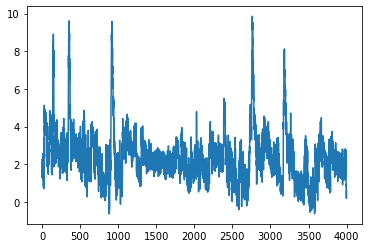

In [ ]:
plt.plot(fair_classifier_loss, label="Fair flows loss")
plt.show()

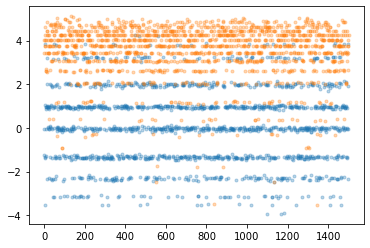

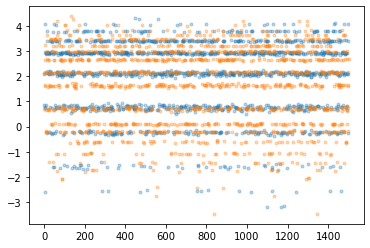

In [ ]:
for i, fair in enumerate(Fairs):
    with torch.no_grad():
        idx = (context_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

        plt.figure()
        plt.plot(embedding_0,'.', alpha=0.3)
        plt.plot(embedding_1,'.', alpha=0.3)
    plt.show()